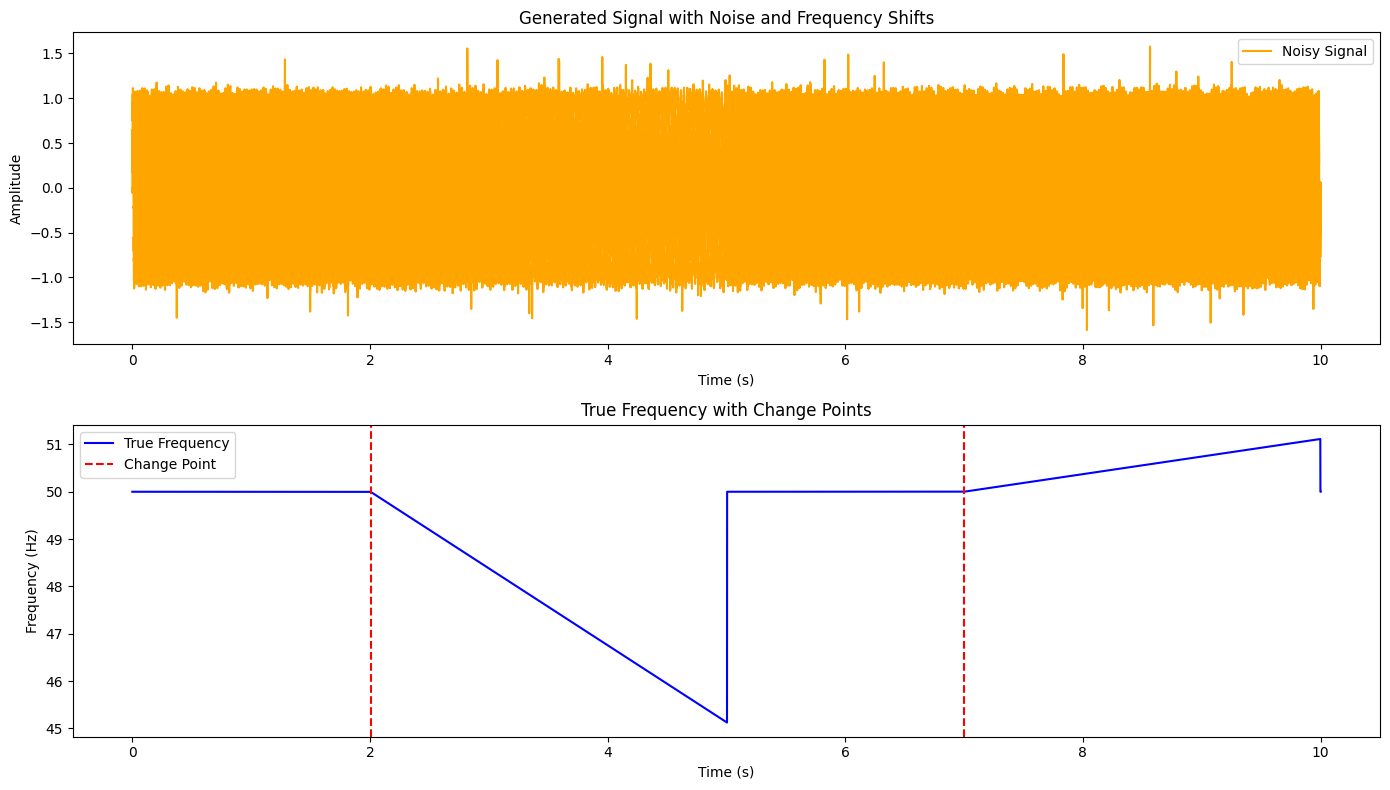

In [21]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Directly use the provided SignalGenerator class
class SignalGenerator:
    def __init__(self, fs=20000, duration=10, f_base=50, f_min=45, f_max=55, mean_interval=2, transition_duration=3, noise_level=0.05):
        self.fs = fs
        self.duration = duration
        self.f_base = f_base
        self.f_min = f_min
        self.f_max = f_max
        self.mean_interval = mean_interval
        self.transition_duration = int(transition_duration * fs)
        self.noise_level = noise_level
        self.time = np.arange(0, self.duration, 1 / self.fs)

    def generate_noisy_signal_with_shifts(self):
        signal = np.sin(2 * np.pi * self.f_base * self.time)
        true_frequency = np.ones(len(self.time)) * self.f_base
        change_points = []

        start = np.random.poisson(self.mean_interval * self.fs)
        while start < len(self.time):
            change_points.append(start / self.fs)
            shift_frequency = np.random.uniform(self.f_min, self.f_max)
            transition_end = min(start + self.transition_duration, len(self.time))

            # Linear shift in frequency within the interval
            true_frequency[start:transition_end] = np.linspace(self.f_base, shift_frequency, transition_end - start)
            signal[start:transition_end] = np.sin(2 * np.pi * true_frequency[start:transition_end] * self.time[start:transition_end])

            if transition_end < len(self.time):
                true_frequency[transition_end:] = self.f_base
                signal[transition_end:] = np.sin(2 * np.pi * self.f_base * self.time[transition_end:])

            start = transition_end + np.random.poisson(self.mean_interval * self.fs)

        signal = self.add_all_noises(signal)
        return signal, true_frequency, change_points

    def add_white_noise(self, signal, level=None):
        level = level if level is not None else self.noise_level
        white_noise = level * np.random.normal(0, 1, len(signal))
        return signal + white_noise

    def add_low_frequency_noise(self, signal, freq=60, level=None):
        level = level if level is not None else self.noise_level * 0.5
        low_freq_noise = level * np.sin(2 * np.pi * freq * self.time)
        return signal + low_freq_noise

    def add_high_frequency_noise(self, signal, freq=500, level=None):
        level = level if level is not None else self.noise_level * 0.3
        high_freq_noise = level * np.sin(2 * np.pi * freq * self.time)
        return signal + high_freq_noise

    def add_harmonics(self, signal, harmonics=[100, 150], levels=[0.2, 0.1]):
        for freq, level in zip(harmonics, levels):
            harmonic_noise = self.noise_level * level * np.sin(2 * np.pi * freq * self.time)
            signal += harmonic_noise
        return signal

    def add_impulsive_noise(self, signal, impulse_rate=0.001, impulse_level=None):
        impulse_level = impulse_level if impulse_level is not None else self.noise_level * np.random.uniform(5, 10)
        num_impulses = int(len(signal) * impulse_rate)
        impulse_indices = np.random.randint(0, len(signal), num_impulses)
        signal[impulse_indices] += impulse_level * np.random.choice([-1, 1], num_impulses)
        return signal

    def add_all_noises(self, signal):
        signal = self.add_white_noise(signal)
        signal = self.add_low_frequency_noise(signal)
        signal = self.add_high_frequency_noise(signal)
        signal = self.add_harmonics(signal)
        signal = self.add_impulsive_noise(signal)
        return signal

# Generate signal using the class
fs = 20000
duration = 10
generator = SignalGenerator(fs=fs, duration=duration, f_base=50, f_min=45, f_max=55, mean_interval=2, transition_duration=3, noise_level=0.05)

# Generate signal and obtain true frequency and change points
signal, true_frequency, change_points = generator.generate_noisy_signal_with_shifts()

# Plot generated signal and true frequency
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Noisy signal plot
ax1.plot(generator.time, signal, color="orange", label="Noisy Signal")
ax1.set_title("Generated Signal with Noise and Frequency Shifts")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Amplitude")
ax1.legend()

# True frequency plot with change points
ax2.plot(generator.time, true_frequency, color="blue", label="True Frequency")
for cp in change_points:
    ax2.axvline(x=cp, color="red", linestyle="--", label="Change Point" if cp == change_points[0] else "")
ax2.set_title("True Frequency with Change Points")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Frequency (Hz)")
ax2.legend()

plt.tight_layout()
plt.show()


In [35]:
import numpy as np
import pandas as pd
import random

def get_100ms_subcuts(time, signal, true_frequency, fs):
    segment_length = int(0.1 * fs)  # 100 ms segment length
    segments = []
    for start in range(0, len(signal), segment_length):
        end = start + segment_length
        if end > len(signal):
            break
        segments.append(((time[start:end], signal[start:end]), (time[start:end], true_frequency[start:end])))
    return segments

# Function to generate dataset from multiple long signals
def generate_large_dataset(num_signals=10, total_duration=60, fs=20000):
    all_data = []

    for _ in range(num_signals):
        f_base = 50
        f_min = random.uniform(45, 49.9)
        f_max = random.uniform(50.1, 55)
        noise_level = random.choice([0.01, 0.05, 0.1])

        # Generate a single long signal
        generator = SignalGenerator(
            fs=fs,
            duration=total_duration,
            f_base=f_base,
            f_min=f_min,
            f_max=f_max,
            mean_interval=2,
            transition_duration=0.03,
            noise_level=noise_level
        )
        long_signal, true_frequency, change_points = generator.generate_noisy_signal_with_shifts()

        # Split into 100 ms segments
        segments = get_100ms_subcuts(np.arange(0, total_duration, 1 / fs), long_signal, true_frequency, fs)

        # Append each segment to the dataset
        for (time_segment, signal_segment), (_, frequency_segment) in segments:
            label = 1 if np.any(frequency_segment != 50) else 0
            all_data.append({'signal': signal_segment, 'label': label})

    # Convert to DataFrame
    df = pd.DataFrame(all_data)
    return df

# Generate large dataset and display the first few rows
df = generate_large_dataset(num_signals=50, total_duration=60, fs=20000)
print(f"Generated dataset size: {len(df)} samples")
df.head()


Generated dataset size: 30000 samples


,signal,label
0,"[-0.034552383355085536, 0.07799964931160962, -...",0
1,"[-0.038599163497909324, -0.11360558395749834, ...",0
2,"[0.04850944486256917, -0.018181713604149587, 0...",0
3,"[-0.13632130332962653, 0.02530656121748896, 0....",0
4,"[0.2067144830334414, 0.005502102004259652, -0....",0


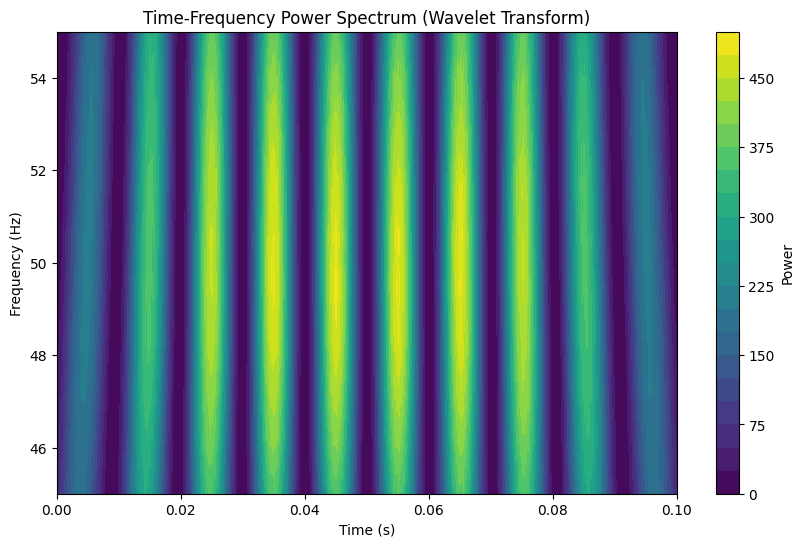

In [36]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

class WaveletAnalyzer:
    def __init__(self, fs, min_freq=45, max_freq=55, wavelet='morl'):
        """
        Initializes the WaveletAnalyzer class for a specific frequency range.

        Parameters:
            fs (int): Sampling frequency in Hz.
            min_freq (float): Minimum frequency for analysis in Hz.
            max_freq (float): Maximum frequency for analysis in Hz.
            wavelet (str): Type of wavelet to use for analysis (default is 'morl').
        """
        self.fs = fs
        self.min_freq = min_freq
        self.max_freq = max_freq
        self.wavelet = wavelet

    def extract_time_frequency_spectrum(self, signal_segment):
        """
        Extracts the time-frequency power spectrum within the 45–55 Hz range from a 100 ms signal segment.

        Parameters:
            signal_segment (ndarray): Array of signal values for the 100 ms segment.

        Returns:
            Tuple of (times, freqs, power_spectrum): Arrays representing the time values within the segment,
            the frequencies analyzed, and the power values for each time-frequency point.
        """
        # Define frequency range for analysis
        freqs = np.linspace(self.min_freq, self.max_freq, num=10)  # Adjust as needed
        scales = pywt.scale2frequency(self.wavelet, freqs) * self.fs
        cwt_coefficients, _ = pywt.cwt(signal_segment, scales, self.wavelet, sampling_period=1/self.fs)
        power_spectrum = np.abs(cwt_coefficients) ** 2
        times = np.linspace(0, 0.1, num=len(signal_segment))  # 100 ms duration
        return times, freqs, power_spectrum

# Example usage with one segment from the dataset
# Get the first signal from the DataFrame
signal_segment = df['signal'].iloc[0]

# Instantiate the wavelet analyzer
fs = 20000  # Sampling frequency
analyzer = WaveletAnalyzer(fs=fs)

# Extract time-frequency spectrum for the first signal segment
times, freqs, power_spectrum = analyzer.extract_time_frequency_spectrum(signal_segment)

# Plot the time-frequency spectrum
plt.figure(figsize=(10, 6))
plt.contourf(times, freqs, power_spectrum, 20, cmap='viridis')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Time-Frequency Power Spectrum (Wavelet Transform)")
plt.colorbar(label="Power")
plt.show()


In [37]:
import numpy as np

def prepare_spectrum_for_nn(df, fs=20000, min_freq=45, max_freq=55, num_freqs=10, num_time_steps=100):
    """
    Transforms each signal's wavelet power spectrum into a format compatible with neural networks.

    Parameters:
        df (pd.DataFrame): DataFrame containing the dataset with columns 'signal' and 'label'.
        fs (int): Sampling frequency in Hz.
        min_freq (float): Minimum frequency for analysis in Hz.
        max_freq (float): Maximum frequency for analysis in Hz.
        num_freqs (int): Number of frequency bins to retain in the spectrum.
        num_time_steps (int): Number of time steps to retain in the spectrum.

    Returns:
        np.ndarray: Array of shape (num_samples, num_freqs, num_time_steps, 1) ready for neural network input.
        np.ndarray: Array of labels corresponding to each sample.
    """
    analyzer = WaveletAnalyzer(fs=fs, min_freq=min_freq, max_freq=max_freq)
    spectra = []
    labels = []

    for _, row in df.iterrows():
        signal_segment = row['signal']
        label = row['label']
        
        # Extract wavelet power spectrum
        _, _, power_spectrum = analyzer.extract_time_frequency_spectrum(signal_segment)
        
        # Resize to the specified shape
        power_spectrum = np.resize(power_spectrum, (num_freqs, num_time_steps))
        
        # Normalize power spectrum
        power_spectrum = (power_spectrum - power_spectrum.min()) / (power_spectrum.max() - power_spectrum.min())
        
        # Add a channel dimension to make it compatible with CNN input
        power_spectrum = power_spectrum[..., np.newaxis]
        
        spectra.append(power_spectrum)
        labels.append(label)
    
    return np.array(spectra), np.array(labels)

# Prepare the data
X, y = prepare_spectrum_for_nn(df)

# Display the shape to confirm
print("Input shape for the neural network:", X.shape)
print("Labels shape:", y.shape)


Input shape for the neural network: (30000, 10, 100, 1)
Labels shape: (30000,)


In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def create_cnn_model(input_shape):
    """
    Builds and compiles a CNN model for binary classification of wavelet power spectrum data.

    Parameters:
        input_shape (tuple): Shape of the input data (num_freqs, num_time_steps, 1).
        
    Returns:
        tf.keras.Model: Compiled CNN model.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Define model input shape based on prepared data
input_shape = X.shape[1:]  # (num_freqs, num_time_steps, 1)

# Create the CNN model
model = create_cnn_model(input_shape)

# Print model summary to verify structure
model.summary()

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X, y, validation_split=0.2, epochs=20, batch_size=16, callbacks=[early_stopping])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 8, 98, 32)         320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 49, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 47, 64)         18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 1, 23, 64)         0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1472)              0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [32]:
model

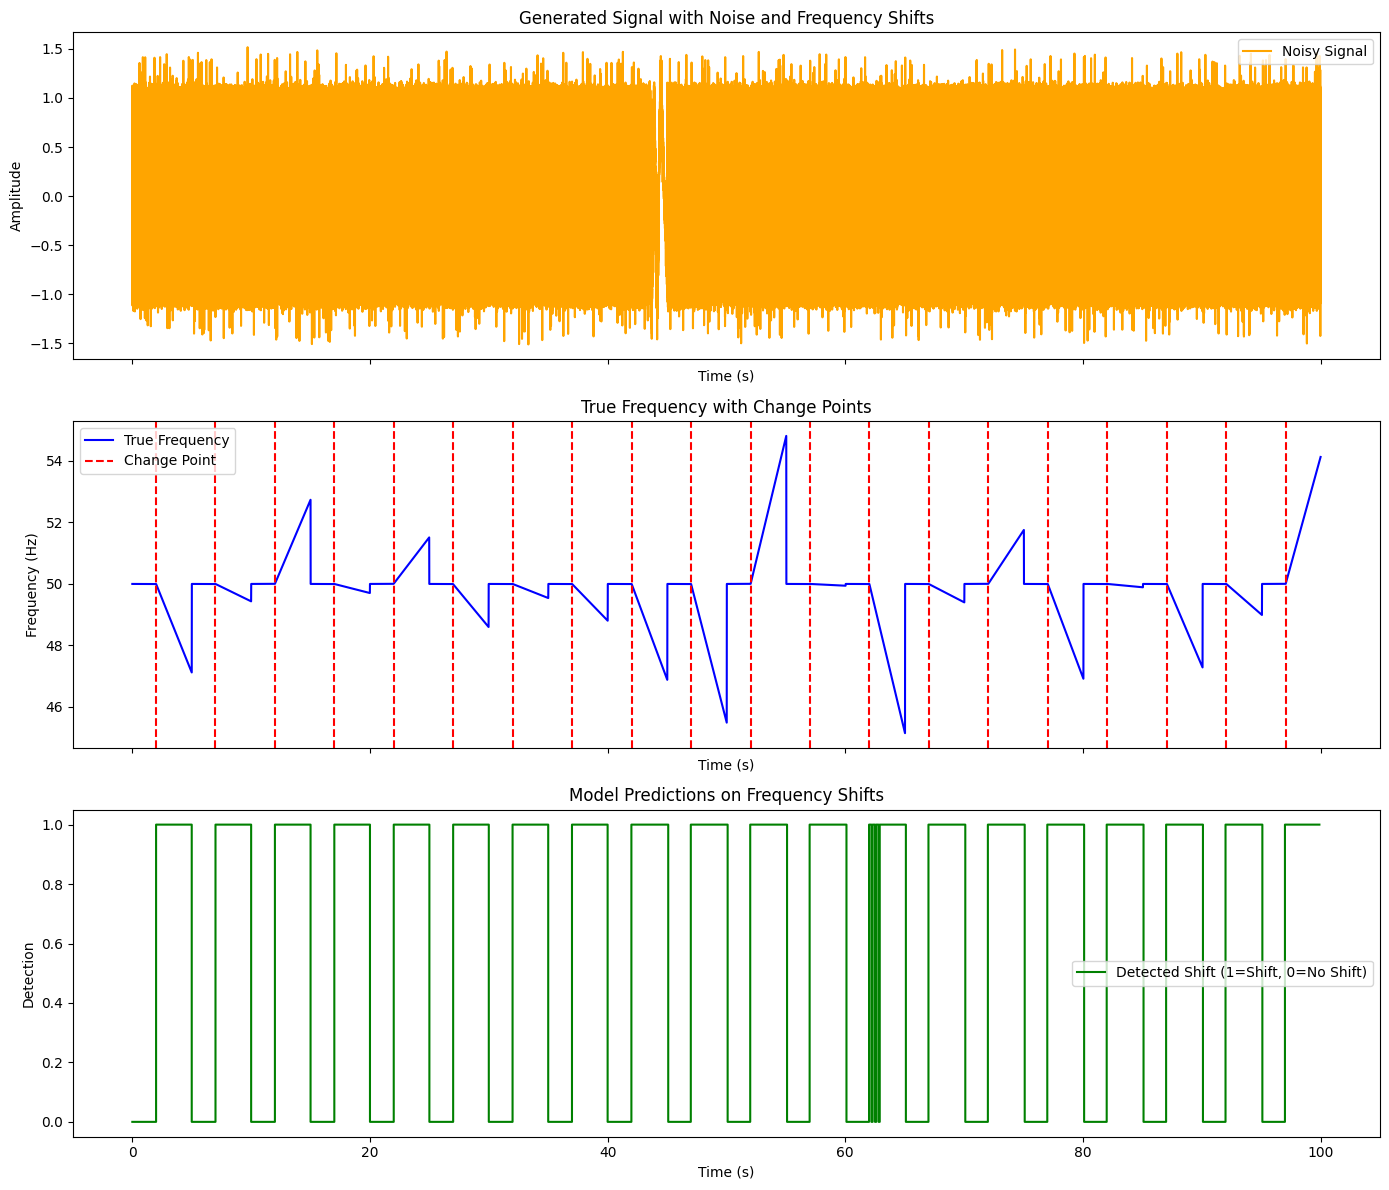

In [39]:
# Generate a new signal and detect frequency shifts in each segment using the trained model
def detect_shifts_in_signal(model, fs=20000, duration=100, f_base=50, f_min=45, f_max=55, mean_interval=2, transition_duration=3, noise_level=0.05):
    # Instantiate and generate a noisy signal with shifts
    generator = SignalGenerator(fs=fs, duration=duration, f_base=f_base, f_min=f_min, f_max=f_max, mean_interval=mean_interval, transition_duration=transition_duration, noise_level=noise_level)
    signal, true_frequency, change_points = generator.generate_noisy_signal_with_shifts()

    # Split the signal into 100 ms sub-cuts
    segments = get_100ms_subcuts(np.arange(0, duration, 1 / fs), signal, true_frequency, fs)
    
    detection_times = []
    detection_results = []

    for (time_segment, signal_segment), (_, frequency_segment) in segments:
        # Extract wavelet spectrum for the segment
        _, _, power_spectrum = analyzer.extract_time_frequency_spectrum(signal_segment)
        power_spectrum = np.resize(power_spectrum, (X.shape[1], X.shape[2]))  # Resize to match model input
        power_spectrum = (power_spectrum - power_spectrum.min()) / (power_spectrum.max() - power_spectrum.min())  # Normalize
        power_spectrum = power_spectrum[..., np.newaxis]  # Add channel dimension

        # Predict using the model
        pred = model.predict(np.array([power_spectrum]), verbose=0)
        predicted_label = int(pred[0][0] > 0.5)  # Threshold at 0.5

        detection_times.append(time_segment[0])  # Start of the segment
        detection_results.append(predicted_label)

    # Plot results
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

    # Noisy signal plot
    ax1.plot(generator.time, signal, color="orange", label="Noisy Signal")
    ax1.set_title("Generated Signal with Noise and Frequency Shifts")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Amplitude")
    ax1.legend()

    # True frequency plot with change points
    ax2.plot(generator.time, true_frequency, color="blue", label="True Frequency")
    for cp in change_points:
        ax2.axvline(x=cp, color="red", linestyle="--", label="Change Point" if cp == change_points[0] else "")
    ax2.set_title("True Frequency with Change Points")
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Frequency (Hz)")
    ax2.legend()

    # Model predictions for each 100 ms segment
    ax3.step(detection_times, detection_results, where='post', color="green", label="Detected Shift (1=Shift, 0=No Shift)")
    ax3.set_title("Model Predictions on Frequency Shifts")
    ax3.set_xlabel("Time (s)")
    ax3.set_ylabel("Detection")
    ax3.legend()

    plt.tight_layout()
    plt.show()

# Apply detection on a new signal using the trained model
detect_shifts_in_signal(model)


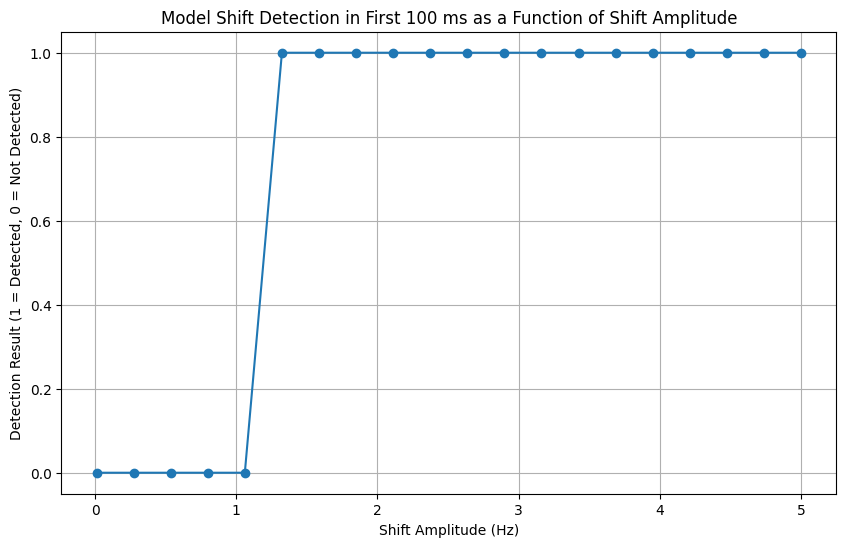

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Create a function to test the model's ability to detect shifts of varying amplitudes
def test_shift_detection(model, fs=20000, duration=0.1, f_base=50, shift_amplitudes=np.linspace(0.01, 5, 20)):
    """
    Tests the model's detection ability on shifts of varying amplitudes.
    
    Parameters:
        model (tf.keras.Model): The trained CNN model.
        fs (int): Sampling frequency in Hz.
        duration (float): Duration of each test segment (100 ms).
        f_base (float): Base frequency (before shift).
        shift_amplitudes (array-like): Array of shift amplitudes to test.
    
    Returns:
        List of detection accuracies for each shift amplitude.
    """
    results = []
    time = np.arange(0, duration, 1 / fs)
    
    for shift in shift_amplitudes:
        # Generate a signal with a linear shift in frequency from f_base to f_base + shift
        true_frequency = np.linspace(f_base, f_base + shift, len(time))
        signal = np.sin(2 * np.pi * true_frequency * time)
        
        # Prepare the segment for model input
        analyzer = WaveletAnalyzer(fs=fs, min_freq=45, max_freq=55)
        _, _, power_spectrum = analyzer.extract_time_frequency_spectrum(signal)
        power_spectrum = np.resize(power_spectrum, (10, 100))
        power_spectrum = (power_spectrum - power_spectrum.min()) / (power_spectrum.max() - power_spectrum.min())
        power_spectrum = power_spectrum[..., np.newaxis]
        
        # Predict with the model
        prediction = model.predict(np.array([power_spectrum]), verbose=0)
        predicted_label = int(prediction[0][0] > 0.5)  # 1 if model detects shift, else 0
        
        # Record if the model correctly detected the shift
        results.append(predicted_label)
    
    return shift_amplitudes, results

# Run the test with the trained model
shift_amplitudes, detection_results = test_shift_detection(model)

# Plot the detection accuracy as a function of shift amplitude
plt.figure(figsize=(10, 6))
plt.plot(shift_amplitudes, detection_results, marker='o', linestyle='-')
plt.xlabel("Shift Amplitude (Hz)")
plt.ylabel("Detection Result (1 = Detected, 0 = Not Detected)")
plt.title("Model Shift Detection in First 100 ms as a Function of Shift Amplitude")
plt.grid(True)
plt.show()


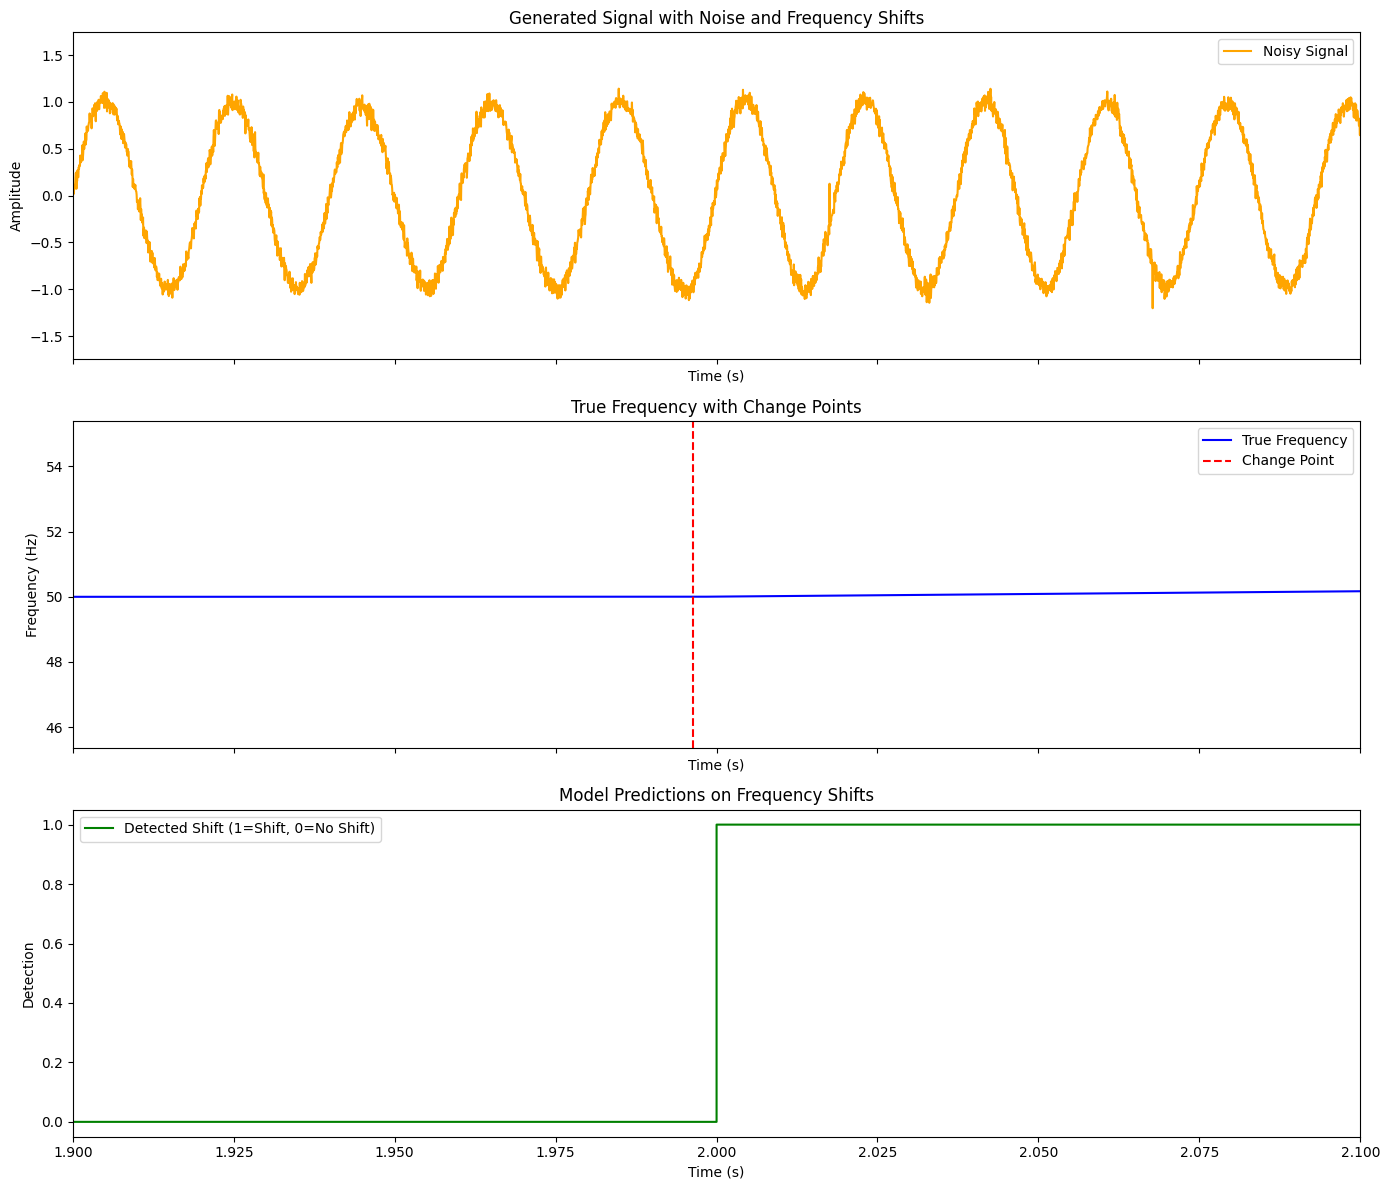

In [41]:
# Generate a new signal and detect frequency shifts in each segment using the trained model
def detect_shifts_in_signal_with_zoom(model, fs=20000, duration=100, f_base=50, f_min=45, f_max=55, mean_interval=2, transition_duration=3, noise_level=0.05):
    # Instantiate and generate a noisy signal with shifts
    generator = SignalGenerator(fs=fs, duration=duration, f_base=f_base, f_min=f_min, f_max=f_max, mean_interval=mean_interval, transition_duration=transition_duration, noise_level=noise_level)
    signal, true_frequency, change_points = generator.generate_noisy_signal_with_shifts()

    # Split the signal into 100 ms sub-cuts
    segments = get_100ms_subcuts(np.arange(0, duration, 1 / fs), signal, true_frequency, fs)
    
    detection_times = []
    detection_results = []
    first_detection_time = None  # To track the first detection time

    for (time_segment, signal_segment), (_, frequency_segment) in segments:
        # Extract wavelet spectrum for the segment
        _, _, power_spectrum = analyzer.extract_time_frequency_spectrum(signal_segment)
        power_spectrum = np.resize(power_spectrum, (X.shape[1], X.shape[2]))  # Resize to match model input
        power_spectrum = (power_spectrum - power_spectrum.min()) / (power_spectrum.max() - power_spectrum.min())  # Normalize
        power_spectrum = power_spectrum[..., np.newaxis]  # Add channel dimension

        # Predict using the model
        pred = model.predict(np.array([power_spectrum]), verbose=0)
        predicted_label = int(pred[0][0] > 0.5)  # Threshold at 0.5

        detection_times.append(time_segment[0])  # Start of the segment
        detection_results.append(predicted_label)

        # Record the first detection time
        if predicted_label == 1 and first_detection_time is None:
            first_detection_time = time_segment[0]

    # Plot results
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

    # Noisy signal plot
    ax1.plot(generator.time, signal, color="orange", label="Noisy Signal")
    ax1.set_title("Generated Signal with Noise and Frequency Shifts")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Amplitude")
    ax1.legend()

    # True frequency plot with change points
    ax2.plot(generator.time, true_frequency, color="blue", label="True Frequency")
    for cp in change_points:
        ax2.axvline(x=cp, color="red", linestyle="--", label="Change Point" if cp == change_points[0] else "")
    ax2.set_title("True Frequency with Change Points")
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Frequency (Hz)")
    ax2.legend()

    # Model predictions for each 100 ms segment
    ax3.step(detection_times, detection_results, where='post', color="green", label="Detected Shift (1=Shift, 0=No Shift)")
    ax3.set_title("Model Predictions on Frequency Shifts")
    ax3.set_xlabel("Time (s)")
    ax3.set_ylabel("Detection")
    ax3.legend()

    # If a detection was made, zoom in on the first detection
    if first_detection_time:
        zoom_start = max(0, first_detection_time - 0.1)  # 100 ms before
        zoom_end = min(duration, first_detection_time + 0.1)  # 100 ms after
        ax1.set_xlim(zoom_start, zoom_end)
        ax2.set_xlim(zoom_start, zoom_end)
        ax3.set_xlim(zoom_start, zoom_end)

    plt.tight_layout()
    plt.show()

# Apply detection on a new signal with zoom on first detection using the trained model
detect_shifts_in_signal_with_zoom(model)
